# Check the SARIMA prediction for every store




In [237]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [238]:
# Loading the data

newtrain = pd.read_csv('data/newtrain.csv')
validation = pd.read_csv('data/validation.csv')

## Preprocessing the data

In [239]:
newtrain.head()

,Unnamed: 0,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,27,2013-01-01,353.0,2.0,3139.0,1.0,0.0,Public,1.0
1,115,2013-01-01,335.0,2.0,2401.0,1.0,0.0,Public,1.0
2,147,2013-01-01,512.0,2.0,2646.0,1.0,0.0,Public,1.0
3,162,2013-01-01,494.0,2.0,3113.0,1.0,0.0,Public,1.0
4,199,2013-01-01,530.0,2.0,2907.0,1.0,0.0,Public,1.0


In [240]:
# checking missing values in Store

newtrain.loc[newtrain['Store'].isnull(), 'Store']

91       NaN
120      NaN
125      NaN
177      NaN
180      NaN
          ..
435759   NaN
435762   NaN
435773   NaN
435794   NaN
435805   NaN
Name: Store, Length: 13246, dtype: float64

In [241]:
# removing for the moment columns with no ID
newtrain_rem = newtrain.drop(newtrain.loc[newtrain['Store'].isnull(), :].index, axis=0)  

# validation
validation_rem = validation.drop(validation.loc[validation['Store'].isnull(), :].index, axis=0)  


In [243]:
# This section is from Sabine


# create new store category based on mean sales
means = newtrain_rem.groupby(['Store']).mean()['Sales']
mapping = {}

limits = [5000, 7500, 10000]
new_cat = ["l", "m", "h", "vh"]
for i, m in enumerate(means):
    mapping[means.index[i]] = new_cat[0]
    for j, l in enumerate(limits):
        if m > l:
            mapping[means.index[i]] = new_cat[j+1]
            


def map_store_category(data, mapping):
    for store, cat in mapping.items():
        data.loc[data['Store'] == store, 'Store_cat'] = cat
        
newtrain_rem['Store_cat'] = "l" 
validation_rem['Store_cat'] = "l"
    
map_store_category(newtrain_rem, mapping) 
map_store_category(validation_rem, mapping)



In [247]:
newtrain_rem.head()

,Unnamed: 0,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Store_cat
0,27,2013-01-01,353.0,2.0,3139.0,1.0,0.0,Public,1.0,l
1,115,2013-01-01,335.0,2.0,2401.0,1.0,0.0,Public,1.0,vh
2,147,2013-01-01,512.0,2.0,2646.0,1.0,0.0,Public,1.0,m
3,162,2013-01-01,494.0,2.0,3113.0,1.0,0.0,Public,1.0,h
4,199,2013-01-01,530.0,2.0,2907.0,1.0,0.0,Public,1.0,l


In [255]:
# number of different stores

len(newtrain_rem['Store_cat'].unique())

4

In [276]:
agg_train = newtrain_rem.groupby(['Date', 'Store_cat'], as_index=False).mean()
agg_val = validation_rem.groupby(['Date', 'Store_cat'], as_index=False).mean()

In [275]:
agg_train.head()

,Date,Store_cat,Unnamed: 0,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday
0,2013-01-01,h,455.500000,795.500000,2.0,4537.000000,1.0,0.0,1.0
1,2013-01-01,l,227.000000,385.666667,2.0,3049.333333,1.0,0.0,1.0
2,2013-01-01,m,494.000000,555.250000,2.0,3794.500000,1.0,0.0,1.0
3,2013-01-01,vh,599.285714,465.142857,2.0,8400.000000,1.0,0.0,1.0
4,2013-01-02,h,1655.181416,552.849558,3.0,8027.778761,1.0,0.0,1.0


In [290]:
# checking behavior of one store sales

store_index = agg_train['Store_cat'].sort_values().unique()
store_index_val = agg_val['Store_cat'].sort_values().unique()

store1 = agg_train.loc[agg_train['Store_cat']==store_index[0], 'Sales']
date1 = agg_val.loc[agg_val['Store_cat']==store_index[0], 'Date']

In [291]:
store_index

array(['h', 'l', 'm', 'vh'], dtype=object)

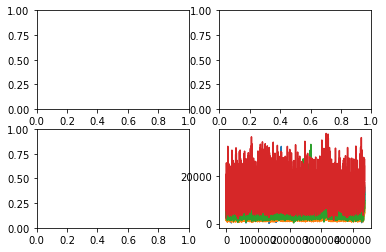

In [292]:
# sales for one store over time
fig, axs = plt.subplots(2, 2)

for i in range(4):
        plt.plot(newtrain_rem.loc[newtrain_rem['Store_cat']==store_index[i], 'Sales'])


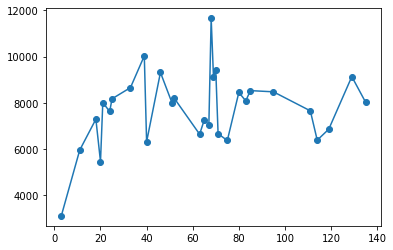

In [284]:
# plot in one month, it shows season of 7 days
plt.plot(store1[:30], '-o')
plt.show()

## SARIMA analysis

In [214]:
# importing packages for Sarima

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima # on order to determine ARIMA orders
from statsmodels.tsa.stattools import adfuller


In [332]:
# define evaluation metrics

def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [ ]:
# 

In [327]:
# SARIMA best model for every store

model_dict = {}
pred = []
start_end = []

for i in range(len(store_index)):
#for i in range(1):    
    
    sale_store = agg_train.loc[agg_train['Store_cat']==store_index[i], 'Sales']
    best_model = auto_arima(sale_store, suppress_warnings=True, start_p=0, start_q=0, m=7)
    
    sale_val = agg_val.loc[agg_val['Store_cat']==store_index_val[i], 'Sales']
        
    assert store_index[i] == store_index_val[i]
    
    start_test = 1 + len(sale_store)
    end_test = start_test + len(sale_val)
    
    start_end.append((start_test, end_test))
    
    model_dict[store_index[i]] = (best_model.order, best_model.seasonal_order)
    pred.append(best_model.predict(start=start_end[i][0], 
                                   end=start_end[i][1],
                                   n_periods=start_end[0][1]-start_end[0][0],
                                   dynamic=False, typ='levels'))

/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,0)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/statsmodels/tsa/statespa

In [328]:
model_dict

{'h': ((2, 0, 0), (2, 0, 2, 7)),
 'l': ((2, 1, 0), (2, 0, 0, 7)),
 'm': ((2, 0, 0), (2, 0, 1, 7)),
 'vh': ((3, 0, 2), (2, 0, 2, 7))}

In [329]:
len(pred)

4

In [364]:
# model + prediction for the first store

import plotly.express as px
import plotly.graph_objects as go

seq_x = range(start_end[0][0] - 1) 
seq_x_cont = range(start_end[0][0], start_end[0][1])

print(len(seq_x_cont))

fig = px.line(
    x=np.array(seq_x), 
    y=agg_train.loc[agg_train['Store_cat']==store_index[0], 'Sales'],
    labels={'x':'t', 'y':'Sales'}
    
)
fig.add_trace(
    go.Scatter(
        x=np.array(seq_x_cont),
        y=pred[0],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        name='Pred',
        showlegend=True)
)
fig.add_trace(
    go.Scatter(
        x=np.array(seq_x_cont),
        y=agg_val.loc[agg_val['Store_cat']==store_index[0], 'Sales'],
        mode="lines",
        line=go.scatter.Line(color="orange"),
        showlegend=False)
)

fig.show()


#plt.plot( seq_x, agg_train.loc[agg_train['Store_cat']==store_index[0], 'Sales'] )
#plt.plot( seq_x_cont, agg_val.loc[agg_val['Store_cat']==store_index[0], 'Sales'] )
#plt.plot( seq_x_cont , pred[0] )
#plt.show()

92


In [369]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1)

for i in range(4):
    fig.add_trace( go.Scatter(
        x=np.array(seq_x), 
        y=agg_train.loc[agg_train['Store_cat']==store_index[i], 'Sales'],
        mode="lines",
        line=go.scatter.Line(color="blue"),
        showlegend=False,
        ),
        row=i+1, 
        col=1           
    )
    fig.add_trace( go.Scatter(
        x=np.array(seq_x_cont),
        y=pred[i],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=True,
        name='Pred ' + store_index[i] , 
        ),
        row=i+1, 
        col=1      
    )
    fig.add_trace(go.Scatter(
        x=np.array(seq_x_cont),
        y=agg_val.loc[agg_val['Store_cat']==store_index[i], 'Sales'],
        mode="lines",
        line=go.scatter.Line(color="orange"),
        showlegend=False),
        row=i+1, 
        col=1         
              
    )


fig.show()

In [352]:
np.array(range(5))

array([0, 1, 2, 3, 4])

In [334]:
#calculating metric per score

metric_store = []

for i in range(len(pred)):
    target_val = np.array(agg_val.loc[agg_val['Store_cat']==store_index_val[i], 'Sales'])
    metric_store.append(metric(pred[i], target_val))



In [368]:
# score per store class

metric_store
print(f'MPSE per store category is {metric_store}')

MPSE per store category is [29.597831966549936, 55.24416346362153, 31.14250593701724, 23.64633305866594]
